# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [1]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 63.75 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [3]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, label
    
    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name), 
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

## Introduction

In this project, we approached the problem of image classification in a progressive and systematic way, starting from very simple configurations and gradually increasing the complexity of both the data preprocessing and the network architecture.

At the beginning, we trained our models with almost no data augmentation, relying on a minimal preprocessing of the images. In parallel, we implemented a very simple convolutional neural network from scratch, composed of a small number of convolutional layers. In this initial phase, the model struggled to learn meaningful representations: the training and validation losses remained high (around 3.5), and the accuracy was almost constant, indicating that the network was not able to fit the data.

We progressively introduced improvements, modifying one component at a time. On the architectural side, we gradually increased the depth of the network by adding additional convolutional blocks and, later, residual blocks, in order to facilitate the optimization of deeper models. On the data side, we incrementally strengthened the data augmentation pipeline to improve robustness and generalization.

As the architecture became deeper, the training accuracy started to increase and the training loss decreased. However, the validation accuracy did not improve, and we have seen a strong overfitting behavior. This highlighted the need for better regularization and more effective augmentation strategies.

By carefully tuning both the network design and the data augmentation, we were eventually able to improve generalization. Using a convolutional network with four convolutional blocks and two residual blocks, we reached a validation accuracy of approximately 40%. This model represents the first architecture presented in the notebook.

Although this result already showed a clear improvement over the initial baseline, it also revealed the limitations of this design. For this reason, we subsequently implemented a different and more structured architecture, which allowed us to further increase performance and achieve significantly higher accuracy. The effectiveness of each design choice is later analyzed through a detailed ablation study.

In [4]:
import random
from collections import Counter
from collections import defaultdict
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import copy
import pandas as pd




## Dataset Analysis
To understand better on what we will work on, we analysed the dataset first. 

* Verification of the split to see the dimension of each one and the number of classes 
* Count how many images we have for each class, for understanding is it's balanced. Sort classes for the index and print the number of images for each class.
* Visualize images and real dimensions





In [5]:
#images to PyTorch tensors 
to_tensor = transforms.ToTensor()

train_ds = OxfordPetDataset(split="train", transform=to_tensor)
val_ds   = OxfordPetDataset(split="val",   transform=to_tensor)
test_ds  = OxfordPetDataset(split="test",  transform=to_tensor)

print("Train:", len(train_ds))
print("Validation:", len(val_ds))
print("Test:", len(test_ds))

num_classes = train_ds.get_num_classes()
print("Classes:", num_classes)


Train: 3669
Validation: 1834
Test: 1846
Classes: 37


In [6]:
def class_counts(dataset):
    return Counter(dataset.labels)

counts = class_counts(train_ds)
sortedlabels = sorted(counts.items(), key=lambda x: x[0])

print("Images per class")
for lab, cnt in sortedlabels:
    print(f"Class {lab}: {cnt} images")

Images per class
Class 0: 98 images
Class 1: 100 images
Class 2: 100 images
Class 3: 100 images
Class 4: 100 images
Class 5: 100 images
Class 6: 100 images
Class 7: 88 images
Class 8: 99 images
Class 9: 100 images
Class 10: 100 images
Class 11: 97 images
Class 12: 100 images
Class 13: 100 images
Class 14: 100 images
Class 15: 100 images
Class 16: 100 images
Class 17: 100 images
Class 18: 99 images
Class 19: 100 images
Class 20: 100 images
Class 21: 100 images
Class 22: 100 images
Class 23: 100 images
Class 24: 100 images
Class 25: 100 images
Class 26: 100 images
Class 27: 100 images
Class 28: 100 images
Class 29: 100 images
Class 30: 99 images
Class 31: 100 images
Class 32: 100 images
Class 33: 100 images
Class 34: 89 images
Class 35: 100 images
Class 36: 100 images


In [7]:
label_to_names = defaultdict(list)

for name, label in zip(train_ds.names, train_ds.labels):
    label_to_names[label].append(name)
    
for lab in range(5):
    print(
        f"Label {lab} "
        f"({len(label_to_names[lab])} images): "
        f"example names {label_to_names[lab][:3]}"
    )

Label 0 (98 images): example names ['Abyssinian_201', 'Abyssinian_202', 'Abyssinian_204']
Label 1 (100 images): example names ['american_bulldog_203', 'american_bulldog_205', 'american_bulldog_207']
Label 2 (100 images): example names ['american_pit_bull_terrier_191', 'american_pit_bull_terrier_192', 'american_pit_bull_terrier_193']
Label 3 (100 images): example names ['basset_hound_191', 'basset_hound_192', 'basset_hound_193']
Label 4 (100 images): example names ['beagle_195', 'beagle_196', 'beagle_197']


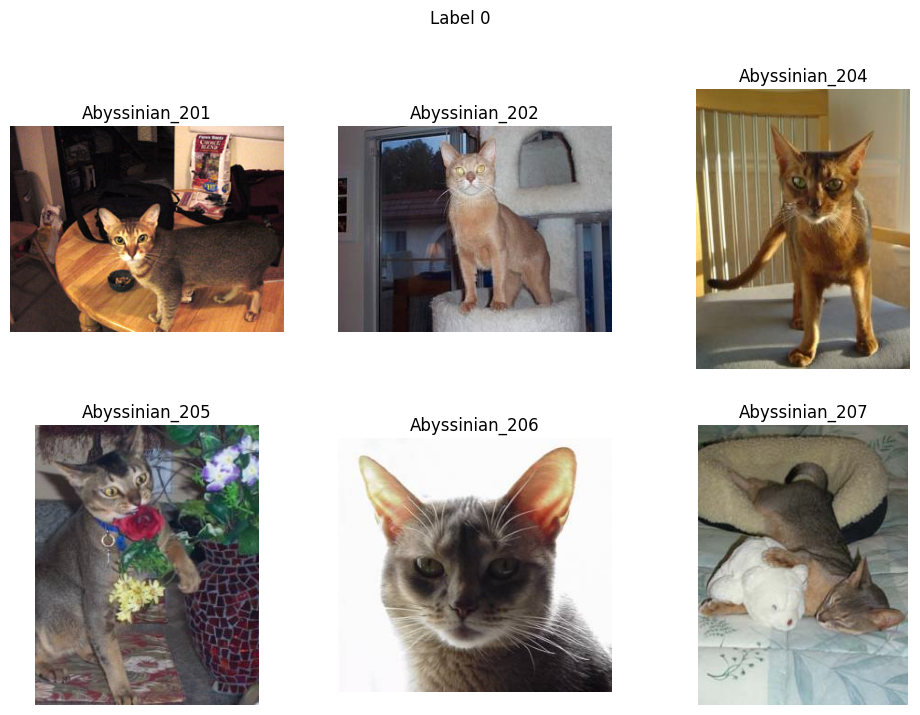

In [8]:
def show_examples_for_label_original(label, n=6, figsize=(12, 8)):
    names = label_to_names[label][:n]
    plt.figure(figsize=figsize)

    for i, nm in enumerate(names):
        img = Image.open(train_ds.root / "images" / f"{nm}.jpg").convert("RGB")
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(nm)
        plt.axis("off")

    plt.suptitle(f"Label {label}")
    plt.show()

# Example of showing images from class 0
show_examples_for_label_original(0, n=6)


## Reproducibility
To ensure reproducible results across different experiments and ablation studies, we fixed the random seed for all the main sources of randomness in our pipeline. All experiments were executed using the same fixed seed, allowing fair and consistent comparisons between different architectures and training configurations.
Whenever available, computations were performed on GPU to accelerate training.


In [9]:
SEED = 115

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


We then count how many predictions are correct in a batch and compute classification accuracy over an entire dataset.

In [10]:
def count_correct_predictions(model_outputs, true_labels):
    #conversion of model outputs to predicted class indices and comparison
    #with ground-truth labels to count correct predictions.
    predicted_labels = torch.argmax(model_outputs, dim=1)
    correct_predictions = (predicted_labels == true_labels).sum()
    return correct_predictions


@torch.no_grad()
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    #total number of correct predictions and total samples starting from zero
    total_correct_predictions = 0   
    total_samples = 0               

    #move data to selected device to get predicted class for each sample
    for images, labels in dataloader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        model_outputs = model(images)

        predicted_labels = torch.argmax(model_outputs, dim=1)

        total_correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

    #accuracy = correct predictions / total samples
    accuracy = total_correct_predictions / total_samples
    return accuracy


## MIXUP
To improve generalization and reduce overfitting as I said before we had a lot of overfitting at the beginning, we employed MixUp data augmentation during training. MixUp generates virtual training samples by linearly combining pairs of images within a mini-batch, together with their corresponding labels. Instead of using pure images, during training two images are taken and mixed together, this avoids the memorizing of the training set and force to learn general features.
The loss function is then computed as a weighted sum of the cross-entropy losses associated with both labels. In our experiments, MixUp significantly reduced overfitting by lowering the gap between training and validation accuracy.

Label smoothing is added to avoid that the model memorize the images, to avoid extreme predictions and to have better ones. Label smoothing helps the model generalize better by softening the target labels.

In [11]:
def apply_mixup(images, labels, alpha=0.2):
    #as input we have a batch of images and their corresponding labels
    #alpha is needed to control the strength of the augmentation and if is zero then is disabled
    #this function returns the mixed images, the original labels, the shuffled labels and the mixing coefficient
   
    if alpha <= 0:
        return images, labels, labels, 1.0

    #mixing coefficient lambda from distribution
    #generate a random permutation of the batch
    lambda_mix = np.random.beta(alpha, alpha)
    batch_indices = torch.randperm(images.size(0), device=images.device)

    # Shuffle images and labels and get shuffled versions
    shuffled_images = images[batch_indices]
    shuffled_labels = labels[batch_indices]
    
    mixed_images = (
        lambda_mix * images +
        (1.0 - lambda_mix) * shuffled_images
    )

    return mixed_images, labels, shuffled_labels, lambda_mix

def mixup_cross_entropy_loss(model_outputs, labels_a, labels_b, lambda_mix, label_smoothing=0.0):
    #this loss function computes the MixUp cross-entropy loss
    #the inputs are the model outputs, the two sets of labels, the mixing coefficient and optional label smoothing
    #labels_a and labels_b are the original and shuffled labels respectively
    #lambda_mix is the mixing coefficient (between 0 and 1) 
    
    loss_a = F.cross_entropy(
        model_outputs,
        labels_a,
        label_smoothing=label_smoothing
    )

    loss_b = F.cross_entropy(
        model_outputs,
        labels_b,
        label_smoothing=label_smoothing
    )

    mixed_loss = (
        lambda_mix * loss_a +
        (1.0 - lambda_mix) * loss_b
    )

    return mixed_loss

## CNN: 4 Convolutional Blocks + Residual Blocks
The architecture is 4 Convolutional Blocks + Residual Blocks. This is the first simple model we implemented. A convolutional neural network trained entirely from scratch. We started from a simple CNN and gradually increased its capacity by adding one convolutional block at a time. Each block follows a VGG-style structure (Conv - BatchNorm - ReLU) repeated twice, followed by MaxPooling to reduce the spatial resolution. The final architecture is four convolutional blocks, increasing the number of channels (64, 128, 256, 512). This allows the network to learn low-level features, edges and textures, in early layers, and more high-level patterns in deeper layers.
We introduced residual blocks at 512 channels. A residual block connections facilitate gradient flow, making training of deeper networks easier

In our experiments, adding residual blocks that compute an output of the form y = x + F(x), where F(x) is a small convolutional transformation improved performance while adding a third residual block led to a performance drop. Increasing depth at the deepest stage introduces extra complexity that does not translate into better generalization and may instead increase overfitting.


In [12]:
class ResidualBlockSameChannels(nn.Module):
    def __init__(self, num_channels: int):
        super().__init__()

        self.convolutional_1 = nn.Conv2d(
            num_channels, num_channels, kernel_size=3, padding=1, bias=False
        )
        self.batch_norm_1 = nn.BatchNorm2d(num_channels)

        self.convolutional_2 = nn.Conv2d(
            num_channels, num_channels, kernel_size=3, padding=1, bias=False
        )
        self.batch_norm_2 = nn.BatchNorm2d(num_channels)

    def forward(self, input_tensor):
        identity = input_tensor

        out = self.convolutional_1(input_tensor)
        out = self.batch_norm_1(out)
        out = F.relu(out, inplace=True)

        out = self.convolutional_2(out)
        out = self.batch_norm_2(out)

        out = out + identity
        out = F.relu(out, inplace=True)
        return out


In [13]:
def convolutional_block(input_channels: int, output_channels: int):
    return nn.Sequential(
        nn.Conv2d(
            input_channels, output_channels,
            kernel_size=3, padding=1, bias=False
        ),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(inplace=True),

        nn.Conv2d(
            output_channels, output_channels,
            kernel_size=3, padding=1, bias=False
        ),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(inplace=True),

        nn.MaxPool2d(kernel_size=2, stride=2),
    )


In [14]:
class CNN_4ConvolutionalBlocks_2ResidualBlocks(nn.Module):
    def __init__(self, num_classes: int, dropout_prob: float = 0.3):
        super().__init__()

        self.convolutional_block_1 = convolutional_block(3, 64)
        self.convolutional_block_2 = convolutional_block(64, 128)
        self.convolutional_block_3 = convolutional_block(128, 256)
        self.convolutional_block_4 = convolutional_block(256, 512)

        self.residual_block_1 = ResidualBlockSameChannels(512)
        self.residual_block_2 = ResidualBlockSameChannels(512)

        self.global_average_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, images):
        features = self.convolutional_block_1(images)
        features = self.convolutional_block_2(features)
        features = self.convolutional_block_3(features)
        features = self.convolutional_block_4(features)

        features = self.residual_block_1(features)
        features = self.residual_block_2(features)

        features = self.global_average_pooling(features)
        features = torch.flatten(features, start_dim=1)
        features = self.dropout(features)

        logits = self.classifier(features)
        return logits


## IMAGE PROCESSING
We computed the mean and standard deviation on the training split, and used these statistics to normalize all images. For training, we applied data augmentation random resized crop, horizontal flip, and random erasing to improve robustness and reduce overfitting. For validation and testing, we used deterministic preprocessing just resize and center crop to ensure fair and stable evaluation.

In [15]:
#transforms for statistics computation
statistics_preprocess_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),   
])

#creation of dataset for statistics computation
training_dataset_for_statistics = OxfordPetDataset(
    split="train",
    transform=statistics_preprocess_transform
)

#dataLoader for statistics computation
training_loader_for_statistics = DataLoader(
    training_dataset_for_statistics,
    batch_size=64,
    shuffle=False,
    num_workers=0,   
    pin_memory=True
)

#mean and std computation initialization
#to calculate sum and sum of squares for each channel
#then we will compute mean and std from these sums
rgb_channel_sum = torch.zeros(3)
rgb_channel_sum_of_squares = torch.zeros(3)
total_number_of_pixels = 0

for batch_images, _ in training_loader_for_statistics:
    batch_size, num_channels, height, width = batch_images.shape

    pixels_in_batch = batch_size * height * width
    total_number_of_pixels += pixels_in_batch

    rgb_channel_sum += batch_images.sum(dim=[0, 2, 3])
    rgb_channel_sum_of_squares += (batch_images ** 2).sum(dim=[0, 2, 3])

training_mean_rgb = rgb_channel_sum / total_number_of_pixels

training_variance_rgb = (rgb_channel_sum_of_squares / total_number_of_pixels) - (training_mean_rgb ** 2)
training_std_rgb = torch.sqrt(training_variance_rgb)

print("Training mean", training_mean_rgb.tolist())
print("Training std", training_std_rgb.tolist())


Training mean [0.4908042252063751, 0.4524926245212555, 0.3973051905632019]
Training std [0.2626195549964905, 0.2577695846557617, 0.26469138264656067]


In [16]:
IMAGE_SIZE = 224
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 128
NUM_DATALOADER_WORKERS = 0

#we used the values we calculated 
TRAINING_SET_MEAN_RGB = (0.4908042550086975, 0.4524926245212555, 0.3973051905632019)
TRAINING_SET_STD_RGB  = (0.2626195549964905, 0.2577695846557617, 0.2646913528442383)

#train transforms with augmentation
training_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5),
    
    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3)),
])

#trasformations for the validation and test sets 
evaluation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),
])

#datasets creation
training_dataset = OxfordPetDataset(split="train", transform=training_transforms)
validation_dataset = OxfordPetDataset(split="val", transform=evaluation_transforms)
test_dataset = OxfordPetDataset(split="test", transform=evaluation_transforms)

#data loaders creation
training_loader = DataLoader(
    training_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

## TRAIN
To train thid model we implemented a training loop in PyTorch dedicated to mix up. We have a training phase, where model parameters are updated through backpropagation, and the validation phase to select the best checkpoint.

the training starts with model.train(), train and validation are separated because dropout and batch normalization, behave differently during the two different phases. 

For each mini-batch of images and labels, data are moved to the selected device. We applied MixUp augmentation to the mini-batch and so create a new batch of mixed images, combining pairs of images in the same batch. As said before the mixed sample is associated with two labels, the original label labels_a and the shuffled label labels_b, along with a mixing coefficient lambda.

A forward pass is then performed on the mixed images to obtain the model outputs. The loss is computed using a MixUp cross-entropy loss, defined as a weighted combination of two standard cross-entropy terms:

* cross-entropy between logits and labels_a, weighted by lambda

* cross-entropy between logits and labels_b, weighted by (1 − lambda)

We apply label smoothing inside the cross-entropy computation and also chacked that without the label smoothing the performances are lower. 

After computing the loss, we perform the standard optimization steps:

* reset gradients (optimizer.zero_grad())
* backpropagation (loss.backward())
* parameter update (optimizer.step())

training accuracy is computed by comparing the predicted class labels with the original ground-truth labels. when MixUp is enabled, this accuracy should be interpreted as indicative because the training inputs are mixed samples and do not correspond to a single and pure label.

After training we have the validation, model.eval(), and we disabled gradients using torch.no_grad() to reduce memory usage and speed up computation. We used standard evaluation, without MixUp and without label smoothing. We compute the average validation loss and validation accuracy over the entire validation split.

validation accuracy is the main criterion we used to decide the best model, while the current validation accuracy improves over the best seen so far, we save a copy of the model parameters as the best. 

We then implemented a learning rate scheduler updated at the end of each epoch, using ReduceLROnPlateau, the scheduler is stepped using the validation loss, allowing the learning rate to decrease when needed.

At the end, During training, we store the epoch-level values of training loss, training accuracy, validation loss, and validation accuracy in a history dictionary to generate plots that visualize convergence and detect overfitting.

In [17]:
def train_model_with_mixup(
    model,
    training_loader,
    num_epochs,
    optimizer,
    device,
    validation_loader=None,
    learning_rate_scheduler=None,
    mixup_alpha=0.2,
    label_smoothing=0.1,
    early_stopping_patience=10,
    print_every=5
):

    best_validation_accuracy = -1.0
    best_model_state_dict = None
    best_epoch_index = -1
    
    epochs_without_improvement = 0

    #for plots
    training_loss_history = []
    training_accuracy_history = []
    validation_loss_history = []
    validation_accuracy_history = []

    for epoch_index in tqdm(range(num_epochs)):

        #training 
        model.train()

        epoch_training_loss_sum = 0.0
        epoch_training_num_correct = 0
        epoch_training_num_samples = 0

        for batch_images, batch_labels in training_loader:
            batch_images = batch_images.to(device, non_blocking=True)
            batch_labels = batch_labels.to(device, non_blocking=True)

            #mixup created before 
            mixed_images, labels_a, labels_b, mixing_lambda = apply_mixup(
                batch_images, batch_labels, alpha=mixup_alpha
            )

            #forward
            model_outputs = model(mixed_images)

            #mixup loss 
            loss_value = mixup_cross_entropy_loss(
                model_outputs=model_outputs,
                labels_a=labels_a,
                labels_b=labels_b,
                lambda_mix=mixing_lambda,
                label_smoothing=label_smoothing
            )

            optimizer.zero_grad(set_to_none=True)
            loss_value.backward()
            optimizer.step()

            batch_size = batch_labels.size(0)
            epoch_training_loss_sum += loss_value.item() * batch_size

            #predict on mixed images, but compare with original labels.
            predicted_labels = torch.argmax(model_outputs, dim=1)
            epoch_training_num_correct += (predicted_labels == batch_labels).sum().item()
            epoch_training_num_samples += batch_size

        epoch_training_loss = epoch_training_loss_sum / epoch_training_num_samples
        epoch_training_accuracy = epoch_training_num_correct / epoch_training_num_samples

        training_loss_history.append(epoch_training_loss)
        training_accuracy_history.append(epoch_training_accuracy)
        
        #validation
        epoch_validation_loss = None
        epoch_validation_accuracy = None

        if validation_loader is not None:
            model.eval()

            epoch_validation_loss_sum = 0.0
            epoch_validation_num_correct = 0
            epoch_validation_num_samples = 0

            with torch.no_grad():
                for batch_images, batch_labels in validation_loader:
                    batch_images = batch_images.to(device, non_blocking=True)
                    batch_labels = batch_labels.to(device, non_blocking=True)

                    model_outputs = model(batch_images)

                    loss_value = F.cross_entropy(model_outputs, batch_labels)

                    batch_size = batch_labels.size(0)
                    epoch_validation_loss_sum += loss_value.item() * batch_size

                    predicted_labels = torch.argmax(model_outputs, dim=1)
                    epoch_validation_num_correct += (predicted_labels == batch_labels).sum().item()
                    epoch_validation_num_samples += batch_size

            epoch_validation_loss = epoch_validation_loss_sum / epoch_validation_num_samples
            epoch_validation_accuracy = epoch_validation_num_correct / epoch_validation_num_samples

            validation_loss_history.append(epoch_validation_loss)
            validation_accuracy_history.append(epoch_validation_accuracy)

            #save best model 
            if epoch_validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = epoch_validation_accuracy
                best_epoch_index = epoch_index
                best_model_state_dict = copy.deepcopy(model.state_dict())
                torch.save(best_model_state_dict, "best_model.pth")
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            #scheduler step
            if learning_rate_scheduler is not None:
                if "ReduceLROnPlateau" in learning_rate_scheduler.__class__.__name__:
                    learning_rate_scheduler.step(epoch_validation_loss)
                else:
                    learning_rate_scheduler.step()
                    
            if epochs_without_improvement >= early_stopping_patience:
                print(
                    f"Early stopping at epoch {epoch_index:03d} "
                    f"Best val acc {best_validation_accuracy:.3f} at epoch {best_epoch_index:03d}."
                )
                break

        #print 
        should_print = (epoch_index % print_every == 0) or (epoch_index == num_epochs - 1)

        if should_print:
            message = (
                f"Epoch {epoch_index:03d} | "
                f"train loss {epoch_training_loss:.3f} train accuracy: {epoch_training_accuracy:.3f}"
            )
            if validation_loader is not None and epoch_validation_loss is not None:
                message += (
                    f" | val loss {epoch_validation_loss:.3f} val accuracy: {epoch_validation_accuracy:.3f}"
                    f" | best val accuracy {best_validation_accuracy:.3f} found at {best_epoch_index:03d} epoch"
                )
            print(message)

    training_history = {
        "train_loss": training_loss_history,
        "train_acc": training_accuracy_history,
        "val_loss": validation_loss_history,
        "val_acc": validation_accuracy_history,
    }

    return best_validation_accuracy, best_model_state_dict, best_epoch_index, training_history


## Training configuration

initialization of the model from scratch every time to ensure a fair comparison across configurations. We use as optimizer AdamW  with weight decay as a regularization term to reduce overfitting.

We used a ReduceLROnPlateau learning-rate scheduler to automatically decrease the learning rate when the validation loss stopped improving.

We applied early stopping with a patience of 10 epochs based on validation accuracy. Training was stopped when validation accuracy did not improve for 10 consecutive epochs.

In [18]:
num_breeds = 37
model_for_experiment = CNN_4ConvolutionalBlocks_2ResidualBlocks(num_classes=num_breeds).to(device)


#AdamW optimizer with learning rate and weight decay
learning_rate = 1e-3
weight_decay = 3e-3

optimizer_adamw = torch.optim.AdamW(
    model_for_experiment.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)


lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_adamw,
    mode="min",
    factor=0.5,
    patience=2
)

#training configuration
num_epochs = 100
mixup_alpha = 0.2
label_smoothing_value = 0.1


best_validation_accuracy, best_model_state_dict, best_epoch_index, training_history = train_model_with_mixup(
    model=model_for_experiment,
    training_loader=training_loader,
    num_epochs=num_epochs,
    optimizer=optimizer_adamw,
    device=device,
    validation_loader=validation_loader,
    learning_rate_scheduler=lr_scheduler,
    mixup_alpha=mixup_alpha,
    label_smoothing=label_smoothing_value,
    early_stopping_patience=10,
    print_every=5
)

print(f"Best validation accuracy: {best_validation_accuracy:.4f} at epoch {best_epoch_index}")

#load best model weights
if best_model_state_dict is not None:
    model_for_experiment.load_state_dict(best_model_state_dict)

#final evaluation on validation and test sets
final_validation_accuracy = evaluate_accuracy(model_for_experiment, validation_loader, device)
final_test_accuracy = evaluate_accuracy(model_for_experiment, test_loader, device)

print("\n final evaluation:")
print("Validation accuracy:", final_validation_accuracy)
print("Test accuracy:", final_test_accuracy)


  1%|          | 1/100 [01:02<1:42:38, 62.20s/it]

Epoch 000 | train loss 3.758 train accuracy: 0.035 | val loss 3.558 val accuracy: 0.054 | best val accuracy 0.054 found at 000 epoch


  6%|▌         | 6/100 [06:04<1:34:36, 60.39s/it]

Epoch 005 | train loss 3.447 train accuracy: 0.055 | val loss 3.448 val accuracy: 0.080 | best val accuracy 0.085 found at 004 epoch


 11%|█         | 11/100 [11:07<1:30:04, 60.73s/it]

Epoch 010 | train loss 3.151 train accuracy: 0.109 | val loss 3.227 val accuracy: 0.149 | best val accuracy 0.149 found at 010 epoch


 16%|█▌        | 16/100 [16:07<1:24:10, 60.12s/it]

Epoch 015 | train loss 2.876 train accuracy: 0.163 | val loss 2.966 val accuracy: 0.179 | best val accuracy 0.179 found at 015 epoch


 21%|██        | 21/100 [21:08<1:19:14, 60.19s/it]

Epoch 020 | train loss 2.532 train accuracy: 0.231 | val loss 2.528 val accuracy: 0.298 | best val accuracy 0.298 found at 020 epoch


 26%|██▌       | 26/100 [26:09<1:14:20, 60.28s/it]

Epoch 025 | train loss 2.441 train accuracy: 0.280 | val loss 2.304 val accuracy: 0.362 | best val accuracy 0.362 found at 025 epoch


 31%|███       | 31/100 [31:09<1:08:58, 59.97s/it]

Epoch 030 | train loss 2.157 train accuracy: 0.286 | val loss 2.280 val accuracy: 0.354 | best val accuracy 0.370 found at 029 epoch


 36%|███▌      | 36/100 [36:08<1:03:55, 59.92s/it]

Epoch 035 | train loss 1.951 train accuracy: 0.356 | val loss 2.171 val accuracy: 0.387 | best val accuracy 0.413 found at 034 epoch


 41%|████      | 41/100 [41:07<58:46, 59.77s/it]  

Epoch 040 | train loss 2.022 train accuracy: 0.392 | val loss 2.045 val accuracy: 0.435 | best val accuracy 0.457 found at 039 epoch


 46%|████▌     | 46/100 [46:08<54:04, 60.09s/it]

Epoch 045 | train loss 1.938 train accuracy: 0.345 | val loss 1.883 val accuracy: 0.475 | best val accuracy 0.475 found at 045 epoch


 51%|█████     | 51/100 [51:07<48:56, 59.93s/it]

Epoch 050 | train loss 1.720 train accuracy: 0.443 | val loss 1.897 val accuracy: 0.465 | best val accuracy 0.475 found at 045 epoch


 56%|█████▌    | 56/100 [56:10<44:24, 60.55s/it]

Epoch 055 | train loss 1.762 train accuracy: 0.374 | val loss 1.874 val accuracy: 0.477 | best val accuracy 0.484 found at 054 epoch


 66%|██████▌   | 66/100 [1:06:12<34:05, 60.16s/it]

Epoch 065 | train loss 1.581 train accuracy: 0.401 | val loss 1.845 val accuracy: 0.481 | best val accuracy 0.487 found at 058 epoch


 71%|███████   | 71/100 [1:11:12<29:03, 60.13s/it]

Epoch 070 | train loss 1.689 train accuracy: 0.511 | val loss 1.811 val accuracy: 0.492 | best val accuracy 0.492 found at 070 epoch


 76%|███████▌  | 76/100 [1:16:12<23:58, 59.94s/it]

Epoch 075 | train loss 1.642 train accuracy: 0.433 | val loss 1.836 val accuracy: 0.487 | best val accuracy 0.492 found at 070 epoch


 80%|████████  | 80/100 [1:21:13<20:18, 60.92s/it]

Early stopping at epoch 080 Best val acc 0.492 at epoch 070.
Best validation accuracy: 0.4924 at epoch 70



 final evaluation:
Validation accuracy: 0.49236641221374045
Test accuracy: 0.5205850487540629


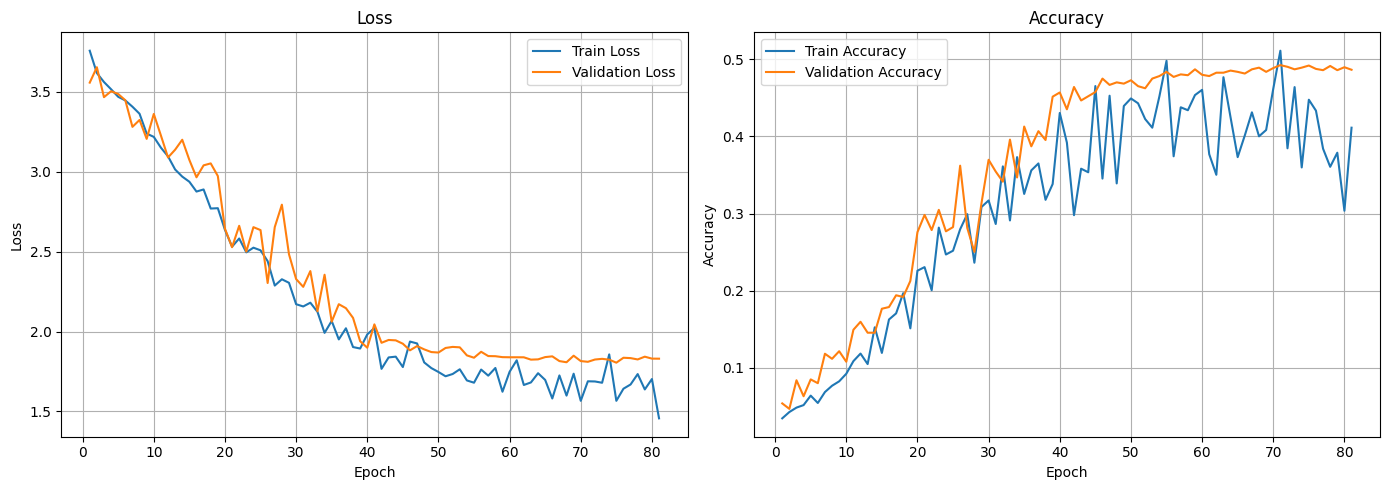

In [19]:
train_losses = training_history["train_loss"]
validation_losses = training_history["val_loss"]
train_accuracy = training_history["train_acc"]
validation_accuracy = training_history["val_acc"]

plt.figure(figsize=(14, 5))

#loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
if len(validation_losses) > 0:
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

#accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label="Train Accuracy")
if len(validation_accuracy) > 0:
    plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
print("\nFinal Results")
print("Best epoch w.r.t validation accuracy:", best_epoch_index)
print("Best validation accuracy:", round(best_validation_accuracy, 4))
print("Final validation accuracy:", round(final_validation_accuracy, 4))
print("Final test accuracy:", round(final_test_accuracy, 4))




Final Results
Best epoch w.r.t validation accuracy: 70
Best validation accuracy: 0.4924
Final validation accuracy: 0.4924
Final test accuracy: 0.5206


## IMPLEMENTATION OF A DIFFERENT CNN
After the anlysis on different hyperparameters we observed that the network above was limited and the 4 convolutional blocks with 2 residual couldn't reach any higher accuracy. We tried a quick ablation on the learning rate, weight decay, dropout, mixup values and these changes never improved the performances, for this reason we decided to try to implement a different network and we started to change one thing at the time, the architecture inspired by RestNet-18 implemented form scratch using PyTorch layers. The motivation behind this change is that fine-grained breed recognition benefits from deeper hierarchical feature extraction and stable optimization, which residual networks provide more effectively. The network we implemented is a CNN, starting from resized images. The network begins with a stem,
a 7×7 convolution with stride 2, Batch Normalization + ReLU and a Max Pooling layer, to reduce the image size while extracting basic visual patterns (for example edges). While the rest of the network focus on more specific breed details. After this first step we have 4 differents steps, residual blocks, that computes transformations using convolutions and the add the original input, the gradient flow more easily. Early, first steps learn small and local features while the later steps learn more global features which in this case is important to define which is the right breed. The steps of residual blocks increasing the number of channels. Finally, global average pooling is used to reduce the number of parameters and try to avoid overfitting, followed by a linear classifier that outputs breed scores.

In [21]:
class BasicResidualBlock(nn.Module):
    
    #residual block with two 3x3 convolutional layers.
    #spatial resolution or the number of channels changes,
    #a downsampling path is applied. 
    def __init__(self, input_channels: int, output_channels: int, stride: int = 1):
        super().__init__()

        self.convolutional_layer_1 = nn.Conv2d(
            input_channels, output_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        
        self.batch_normalization_1 = nn.BatchNorm2d(output_channels)
        
        self.convolutional_layer_2 = nn.Conv2d(
            output_channels, output_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.batch_normalization_2 = nn.BatchNorm2d(output_channels)

        self.identity_downsampling = None
        if stride != 1 or input_channels != output_channels:
            self.identity_downsampling = nn.Sequential(
                nn.Conv2d(
                    input_channels, output_channels,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(output_channels)
            )

    def forward(self, input_tensor):
        identity_tensor = input_tensor

        out = self.convolutional_layer_1(input_tensor)
        out = self.batch_normalization_1(out)
        out = F.relu(out, inplace=True)

        out = self.convolutional_layer_2(out)
        out = self.batch_normalization_2(out)

        if self.identity_downsampling is not None:
            identity_tensor = self.identity_downsampling(input_tensor)

        out = out + identity_tensor
        out = F.relu(out, inplace=True)

        return out


In [22]:
class DeepResidualCNN(nn.Module):
    #stem: 7x7 convolution + BatchNorm + ReLU + MaxPool
    #4 steps, each composed of 2 residual blocks: 64 channels, 128 channels, 256 channels, 512 channels 
    #global Average Pooling
    #dropout
    #linear classifier

    def __init__(self, num_classes: int = 37, dropout_probability: float = 0.0):
        super().__init__()

        self.current_num_channels = 64

        self.stem_feature_extractor = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=64,
                kernel_size=7, stride=2, padding=3, bias=False
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        #residual steps - feature learning 
        #56x56 - 56x56
        #56x56 - 28x28
        #28x28 - 14x14
        #14x14 - 7x7
        self.step_1 = self._build_residual_step(
            output_channels=64,
            num_blocks=2,
            first_block_stride=1
        )  
        
        self.step_2 = self._build_residual_step(
            output_channels=128,
            num_blocks=2,
            first_block_stride=2
        )  

        self.step_3 = self._build_residual_step(
            output_channels=256,
            num_blocks=2,
            first_block_stride=2
        ) 

        self.step_4 = self._build_residual_step(
            output_channels=512,
            num_blocks=2,
            first_block_stride=2
        ) 

        #head classification 
        self.global_average_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout_layer = nn.Dropout(p=dropout_probability)
        self.classifier_layer = nn.Linear(512, num_classes)

        #initialization for convolutional layers
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")

    def _build_residual_step(self, output_channels: int, num_blocks: int, first_block_stride: int):
        residual_blocks = []

        residual_blocks.append(
            BasicResidualBlock(
                input_channels=self.current_num_channels,
                output_channels=output_channels,
                stride=first_block_stride
            )
        )
        self.current_num_channels = output_channels

        for _ in range(1, num_blocks):
            residual_blocks.append(
                BasicResidualBlock(
                    input_channels=self.current_num_channels,
                    output_channels=output_channels,
                    stride=1
                )
            )

        return nn.Sequential(*residual_blocks)

    def forward(self, input_images):
        features = self.stem_feature_extractor(input_images)

        features = self.step_1(features)
        features = self.step_2(features)
        features = self.step_3(features)
        features = self.step_4(features)

        features = self.global_average_pooling(features)
        features = torch.flatten(features, start_dim=1)
        features = self.dropout_layer(features)

        logits = self.classifier_layer(features)
        return logits


Now that we implemented this network that will show the best results, we will show that we also changed the augmentation of the training images, while we did not change anything on the training loop tp keep the same code, the augmentation has changed, the mean and the standard deviation we have are the same as we calculated at the beginning. To improve generalization and reduce overfitting, we introduced stronger data augmentation techniques during training. To have a stronger variation of content on the images. 

* Random Erasing removes a small random part of the image during training. The model can't focus only on one specific detail and forces it to look at different parts of the image and is needed to be less sensitive.
* Color Jitter changes brightness, contrast, saturation, and hue of the images to be able to handle different lighting conditions and avoid to relying too much on specific colors.
* RandAugment automatically applies a small number of random image transformations with a fixed strength.

The combination of these techniques increases the diversity of the training images.

In [23]:
IMAGE_SIZE = 224
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 128
NUM_DATALOADER_WORKERS = 0

TRAINING_SET_MEAN_RGB = (0.4908042550086975, 0.4524926245212555, 0.3973051905632019)
TRAINING_SET_STD_RGB  = (0.2626195549964905, 0.2577695846557617, 0.2646913528442383)


training_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.15,
        hue=0.02
    ),

    transforms.RandAugment(num_ops=2, magnitude=9),

    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),

    transforms.RandomErasing(
        p=0.25,
        scale=(0.02, 0.12),
        ratio=(0.3, 3.3)
    ),
])


evaluation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),
])

training_dataset = OxfordPetDataset(split="train", transform=training_transforms)
validation_dataset = OxfordPetDataset(split="val", transform=evaluation_transforms)
test_dataset = OxfordPetDataset(split="test", transform=evaluation_transforms)


training_loader = DataLoader(
    training_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)


In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = DeepResidualCNN(num_classes=37, dropout_probability=0.3).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4,
    weight_decay=2e-3
)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)

num_epochs = 100

best_val_acc, best_params, best_epoch, history = train_model_with_mixup(
    model=model,
    training_loader=training_loader,         
    num_epochs=num_epochs,
    optimizer=optimizer,
    device=device,
    validation_loader=validation_loader,         
    learning_rate_scheduler=lr_scheduler,
    mixup_alpha=0.2,
    label_smoothing=0.1,
    early_stopping_patience=15,
    print_every=5
)

if best_params is not None:
    model.load_state_dict(best_params)

print("Best epoch:", best_epoch)
final_val_acc = evaluate_accuracy(model, validation_loader, device)
final_test_acc = evaluate_accuracy(model, test_loader, device)

print("Validation accuracy:", final_val_acc)
print("Test accuracy:", final_test_acc)

train_losses = history["train_loss"]
val_losses   = history["val_loss"]
train_accs   = history["train_acc"]
val_accs     = history["val_acc"]


Device: cuda


  1%|          | 1/100 [01:00<1:40:00, 60.61s/it]

Epoch 000 | train loss 3.654 train accuracy: 0.041 | val loss 4.012 val accuracy: 0.068 | best val accuracy 0.068 found at 000 epoch


  6%|▌         | 6/100 [06:00<1:34:11, 60.12s/it]

Epoch 005 | train loss 3.199 train accuracy: 0.086 | val loss 3.170 val accuracy: 0.131 | best val accuracy 0.154 found at 004 epoch


 11%|█         | 11/100 [10:58<1:28:24, 59.60s/it]

Epoch 010 | train loss 2.928 train accuracy: 0.151 | val loss 2.710 val accuracy: 0.226 | best val accuracy 0.226 found at 010 epoch


 16%|█▌        | 16/100 [15:55<1:23:09, 59.40s/it]

Epoch 015 | train loss 2.578 train accuracy: 0.198 | val loss 2.674 val accuracy: 0.272 | best val accuracy 0.287 found at 013 epoch


 21%|██        | 21/100 [20:52<1:18:00, 59.25s/it]

Epoch 020 | train loss 2.266 train accuracy: 0.264 | val loss 2.192 val accuracy: 0.393 | best val accuracy 0.393 found at 020 epoch


 26%|██▌       | 26/100 [25:48<1:13:07, 59.29s/it]

Epoch 025 | train loss 2.010 train accuracy: 0.352 | val loss 2.001 val accuracy: 0.420 | best val accuracy 0.420 found at 025 epoch


 31%|███       | 31/100 [30:44<1:08:03, 59.18s/it]

Epoch 030 | train loss 1.870 train accuracy: 0.419 | val loss 1.633 val accuracy: 0.526 | best val accuracy 0.526 found at 030 epoch


 36%|███▌      | 36/100 [35:40<1:03:12, 59.25s/it]

Epoch 035 | train loss 1.630 train accuracy: 0.501 | val loss 1.475 val accuracy: 0.597 | best val accuracy 0.597 found at 035 epoch


 41%|████      | 41/100 [40:36<58:14, 59.24s/it]  

Epoch 040 | train loss 1.560 train accuracy: 0.382 | val loss 1.451 val accuracy: 0.606 | best val accuracy 0.606 found at 040 epoch


 46%|████▌     | 46/100 [45:32<53:16, 59.19s/it]

Epoch 045 | train loss 1.521 train accuracy: 0.434 | val loss 1.447 val accuracy: 0.611 | best val accuracy 0.611 found at 045 epoch


 51%|█████     | 51/100 [50:28<48:19, 59.16s/it]

Epoch 050 | train loss 1.530 train accuracy: 0.419 | val loss 1.451 val accuracy: 0.613 | best val accuracy 0.623 found at 046 epoch


 56%|█████▌    | 56/100 [55:24<43:27, 59.26s/it]

Epoch 055 | train loss 1.608 train accuracy: 0.525 | val loss 1.434 val accuracy: 0.618 | best val accuracy 0.631 found at 051 epoch


 61%|██████    | 61/100 [1:00:21<38:38, 59.45s/it]

Epoch 060 | train loss 1.451 train accuracy: 0.520 | val loss 1.406 val accuracy: 0.625 | best val accuracy 0.635 found at 059 epoch


 66%|██████▌   | 66/100 [1:05:17<33:33, 59.23s/it]

Epoch 065 | train loss 1.278 train accuracy: 0.452 | val loss 1.411 val accuracy: 0.626 | best val accuracy 0.635 found at 059 epoch


 71%|███████   | 71/100 [1:10:14<28:41, 59.37s/it]

Epoch 070 | train loss 1.471 train accuracy: 0.497 | val loss 1.403 val accuracy: 0.637 | best val accuracy 0.637 found at 070 epoch


 76%|███████▌  | 76/100 [1:15:11<23:44, 59.35s/it]

Epoch 075 | train loss 1.404 train accuracy: 0.462 | val loss 1.410 val accuracy: 0.631 | best val accuracy 0.638 found at 073 epoch


 81%|████████  | 81/100 [1:20:07<18:48, 59.41s/it]

Epoch 080 | train loss 1.466 train accuracy: 0.400 | val loss 1.412 val accuracy: 0.636 | best val accuracy 0.638 found at 073 epoch


 86%|████████▌ | 86/100 [1:25:05<13:52, 59.49s/it]

Epoch 085 | train loss 1.458 train accuracy: 0.516 | val loss 1.400 val accuracy: 0.641 | best val accuracy 0.641 found at 085 epoch


 91%|█████████ | 91/100 [1:30:02<08:55, 59.47s/it]

Epoch 090 | train loss 1.407 train accuracy: 0.425 | val loss 1.396 val accuracy: 0.636 | best val accuracy 0.641 found at 085 epoch


 96%|█████████▌| 96/100 [1:35:00<03:58, 59.52s/it]

Epoch 095 | train loss 1.397 train accuracy: 0.490 | val loss 1.409 val accuracy: 0.632 | best val accuracy 0.641 found at 085 epoch


100%|██████████| 100/100 [1:38:58<00:00, 59.39s/it]

Epoch 099 | train loss 1.312 train accuracy: 0.368 | val loss 1.405 val accuracy: 0.630 | best val accuracy 0.641 found at 085 epoch
Best epoch: 85


Validation accuracy: 0.6412213740458015
Test accuracy: 0.6728060671722643


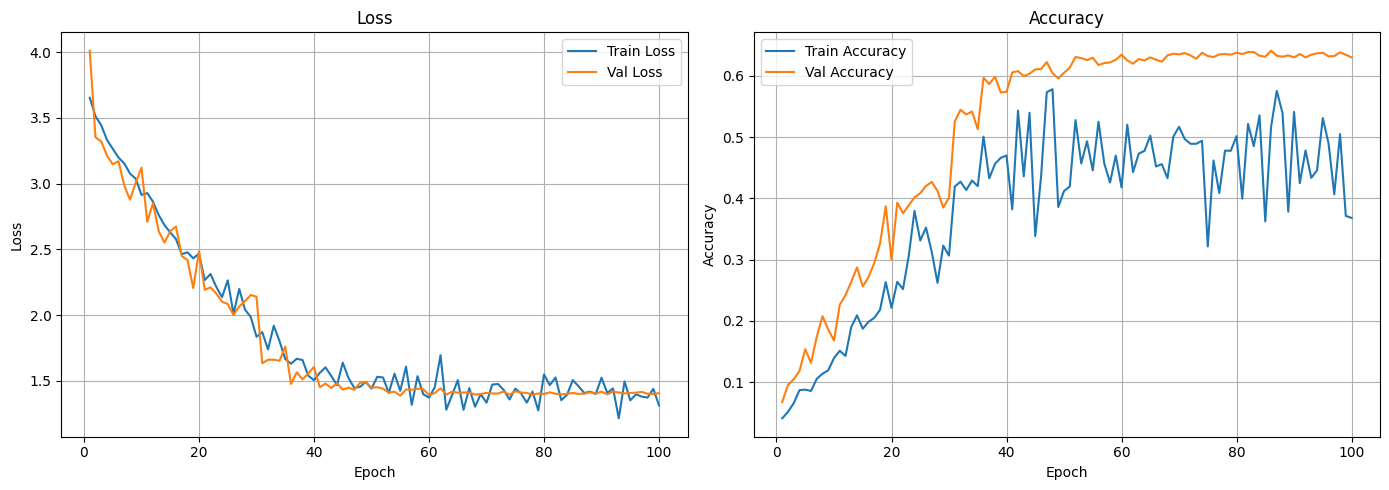

In [25]:
#n = max(len(train_losses), len(val_losses), len(train_accs), len(val_accs))
#epochs = range(1, n + 1)

plt.figure(figsize=(14, 5))

#loss
plt.subplot(1, 2, 1)
if len(train_losses) > 0:
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
plt.legend(); plt.grid(True)

#accuracy
plt.subplot(1, 2, 2)
if len(train_accs) > 0:
    plt.plot(range(1, len(train_accs)+1), train_accs, label="Train Accuracy")
plt.plot(range(1, len(val_accs)+1), val_accs, label="Val Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


In [26]:
print("\nFinal Results")
print("Best epoch w.r.t validation accuracy:", best_epoch)
print("Best validation accuracy:", round(best_val_acc, 4))
print("Final validation accuracy:", round(final_val_acc, 4))
print("Final test accuracy:", round(final_test_acc, 4))




Final Results
Best epoch w.r.t validation accuracy: 85
Best validation accuracy: 0.6412
Final validation accuracy: 0.6412
Final test accuracy: 0.6728


# Consideration on the best model found so far
The model was trained with the following configuration:

* Optimizer: AdamW
* Learning rate: 5e-4
* Weight decay: 2e-3
* Batch size: 64 (train), 128 (val/test)
* Loss regularization:
* Mixup (α = 0.2)
* Label smoothing (ε = 0.1)
* Learning rate scheduler: ReduceLROnPlateau 
* Early stopping: patience = 15

These are the choices we made to regularize the model and to reduce overfitting when training. 

Training loss and validation loss decrease, with no divergence between them and so is not present overfitting. 
The Accuracy of the validation test split is higher than the train accuracy which is good for our settings because the augmentation is strong on training while is not on validation, on validation we have a normal and standard image processing and it's easier. Mixup and label smoothing make training labels more soft.

The model show convergence, no overfitting, and the behaviour follow the strong regulation we imposed.  



# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [1]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 63.25 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [3]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, label
    
    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name), 
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

In [4]:
import random
from collections import Counter
from collections import defaultdict
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import copy
import pandas as pd




In [5]:
SEED = 115

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


We then count how many predictions are correct in a batch and compute classification accuracy over an entire dataset.

In [6]:
def count_correct_predictions(model_outputs, true_labels):
    #conversion of model outputs to predicted class indices and comparison
    #with ground-truth labels to count correct predictions.
    predicted_labels = torch.argmax(model_outputs, dim=1)
    correct_predictions = (predicted_labels == true_labels).sum()
    return correct_predictions


@torch.no_grad()
def evaluate_accuracy(model, dataloader, device):
    model.eval()
    #total number of correct predictions and total samples starting from zero
    total_correct_predictions = 0   
    total_samples = 0               

    #move data to selected device to get predicted class for each sample
    for images, labels in dataloader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        model_outputs = model(images)

        predicted_labels = torch.argmax(model_outputs, dim=1)

        total_correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

    #accuracy = correct predictions / total samples
    accuracy = total_correct_predictions / total_samples
    return accuracy


In [7]:
def apply_mixup(images, labels, alpha=0.2):
    #as input we have a batch of images and their corresponding labels
    #alpha is needed to control the strength of the augmentation and if is zero then is disabled
    #this function returns the mixed images, the original labels, the shuffled labels and the mixing coefficient
   
    if alpha <= 0:
        return images, labels, labels, 1.0

    #mixing coefficient lambda from distribution
    #generate a random permutation of the batch
    lambda_mix = np.random.beta(alpha, alpha)
    batch_indices = torch.randperm(images.size(0), device=images.device)

    # Shuffle images and labels and get shuffled versions
    shuffled_images = images[batch_indices]
    shuffled_labels = labels[batch_indices]
    
    mixed_images = (
        lambda_mix * images +
        (1.0 - lambda_mix) * shuffled_images
    )

    return mixed_images, labels, shuffled_labels, lambda_mix

def mixup_cross_entropy_loss(model_outputs, labels_a, labels_b, lambda_mix, label_smoothing=0.0):
    #this loss function computes the MixUp cross-entropy loss
    #the inputs are the model outputs, the two sets of labels, the mixing coefficient and optional label smoothing
    #labels_a and labels_b are the original and shuffled labels respectively
    #lambda_mix is the mixing coefficient (between 0 and 1) 
    
    loss_a = F.cross_entropy(
        model_outputs,
        labels_a,
        label_smoothing=label_smoothing
    )

    loss_b = F.cross_entropy(
        model_outputs,
        labels_b,
        label_smoothing=label_smoothing
    )

    mixed_loss = (
        lambda_mix * loss_a +
        (1.0 - lambda_mix) * loss_b
    )

    return mixed_loss

In [8]:
def train_model_with_mixup(
    model,
    training_loader,
    num_epochs,
    optimizer,
    device,
    validation_loader=None,
    learning_rate_scheduler=None,
    mixup_alpha=0.2,
    label_smoothing=0.1,
    early_stopping_patience=10,
    print_every=5
):

    best_validation_accuracy = -1.0
    best_model_state_dict = None
    best_epoch_index = -1
    
    epochs_without_improvement = 0

    #for plots
    training_loss_history = []
    training_accuracy_history = []
    validation_loss_history = []
    validation_accuracy_history = []

    for epoch_index in tqdm(range(num_epochs)):

        #training 
        model.train()

        epoch_training_loss_sum = 0.0
        epoch_training_num_correct = 0
        epoch_training_num_samples = 0

        for batch_images, batch_labels in training_loader:
            batch_images = batch_images.to(device, non_blocking=True)
            batch_labels = batch_labels.to(device, non_blocking=True)

            #mixup created before 
            mixed_images, labels_a, labels_b, mixing_lambda = apply_mixup(
                batch_images, batch_labels, alpha=mixup_alpha
            )

            #forward
            model_outputs = model(mixed_images)

            #mixup loss 
            loss_value = mixup_cross_entropy_loss(
                model_outputs=model_outputs,
                labels_a=labels_a,
                labels_b=labels_b,
                lambda_mix=mixing_lambda,
                label_smoothing=label_smoothing
            )

            optimizer.zero_grad(set_to_none=True)
            loss_value.backward()
            optimizer.step()

            batch_size = batch_labels.size(0)
            epoch_training_loss_sum += loss_value.item() * batch_size

            #predict on mixed images, but compare with original labels.
            predicted_labels = torch.argmax(model_outputs, dim=1)
            epoch_training_num_correct += (predicted_labels == batch_labels).sum().item()
            epoch_training_num_samples += batch_size

        epoch_training_loss = epoch_training_loss_sum / epoch_training_num_samples
        epoch_training_accuracy = epoch_training_num_correct / epoch_training_num_samples

        training_loss_history.append(epoch_training_loss)
        training_accuracy_history.append(epoch_training_accuracy)
        
        #validation
        epoch_validation_loss = None
        epoch_validation_accuracy = None

        if validation_loader is not None:
            model.eval()

            epoch_validation_loss_sum = 0.0
            epoch_validation_num_correct = 0
            epoch_validation_num_samples = 0

            with torch.no_grad():
                for batch_images, batch_labels in validation_loader:
                    batch_images = batch_images.to(device, non_blocking=True)
                    batch_labels = batch_labels.to(device, non_blocking=True)

                    model_outputs = model(batch_images)

                    loss_value = F.cross_entropy(model_outputs, batch_labels)

                    batch_size = batch_labels.size(0)
                    epoch_validation_loss_sum += loss_value.item() * batch_size

                    predicted_labels = torch.argmax(model_outputs, dim=1)
                    epoch_validation_num_correct += (predicted_labels == batch_labels).sum().item()
                    epoch_validation_num_samples += batch_size

            epoch_validation_loss = epoch_validation_loss_sum / epoch_validation_num_samples
            epoch_validation_accuracy = epoch_validation_num_correct / epoch_validation_num_samples

            validation_loss_history.append(epoch_validation_loss)
            validation_accuracy_history.append(epoch_validation_accuracy)

            #save best model 
            if epoch_validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = epoch_validation_accuracy
                best_epoch_index = epoch_index
                best_model_state_dict = copy.deepcopy(model.state_dict())
                torch.save(best_model_state_dict, "best_model.pth")
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            #scheduler step
            if learning_rate_scheduler is not None:
                if "ReduceLROnPlateau" in learning_rate_scheduler.__class__.__name__:
                    learning_rate_scheduler.step(epoch_validation_loss)
                else:
                    learning_rate_scheduler.step()
                    
            if epochs_without_improvement >= early_stopping_patience:
                print(
                    f"Early stopping at epoch {epoch_index:03d} "
                    f"Best val acc {best_validation_accuracy:.3f} at epoch {best_epoch_index:03d}."
                )
                break

        #print 
        should_print = (epoch_index % print_every == 0) or (epoch_index == num_epochs - 1)

        if should_print:
            message = (
                f"Epoch {epoch_index:03d} | "
                f"train loss {epoch_training_loss:.3f} train accuracy: {epoch_training_accuracy:.3f}"
            )
            if validation_loader is not None and epoch_validation_loss is not None:
                message += (
                    f" | val loss {epoch_validation_loss:.3f} val accuracy: {epoch_validation_accuracy:.3f}"
                    f" | best val accuracy {best_validation_accuracy:.3f} found at {best_epoch_index:03d} epoch"
                )
            print(message)

    training_history = {
        "train_loss": training_loss_history,
        "train_acc": training_accuracy_history,
        "val_loss": validation_loss_history,
        "val_acc": validation_accuracy_history,
    }

    return best_validation_accuracy, best_model_state_dict, best_epoch_index, training_history


In [9]:
class BasicResidualBlock(nn.Module):
    
    #residual block with two 3x3 convolutional layers.
    #spatial resolution or the number of channels changes,
    #a downsampling path is applied. 
    def __init__(self, input_channels: int, output_channels: int, stride: int = 1):
        super().__init__()

        self.convolutional_layer_1 = nn.Conv2d(
            input_channels, output_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        
        self.batch_normalization_1 = nn.BatchNorm2d(output_channels)
        
        self.convolutional_layer_2 = nn.Conv2d(
            output_channels, output_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.batch_normalization_2 = nn.BatchNorm2d(output_channels)

        self.identity_downsampling = None
        if stride != 1 or input_channels != output_channels:
            self.identity_downsampling = nn.Sequential(
                nn.Conv2d(
                    input_channels, output_channels,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(output_channels)
            )

    def forward(self, input_tensor):
        identity_tensor = input_tensor

        out = self.convolutional_layer_1(input_tensor)
        out = self.batch_normalization_1(out)
        out = F.relu(out, inplace=True)

        out = self.convolutional_layer_2(out)
        out = self.batch_normalization_2(out)

        if self.identity_downsampling is not None:
            identity_tensor = self.identity_downsampling(input_tensor)

        out = out + identity_tensor
        out = F.relu(out, inplace=True)

        return out


In [10]:
class DeepResidualCNN(nn.Module):
    #stem: 7x7 convolution + BatchNorm + ReLU + MaxPool
    #4 steps, each composed of 2 residual blocks: 64 channels, 128 channels, 256 channels, 512 channels 
    #global Average Pooling
    #dropout
    #linear classifier

    def __init__(self, num_classes: int = 37, dropout_probability: float = 0.0):
        super().__init__()

        self.current_num_channels = 64

        self.stem_feature_extractor = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=64,
                kernel_size=7, stride=2, padding=3, bias=False
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        #residual steps - feature learning 
        #56x56 - 56x56
        #56x56 - 28x28
        #28x28 - 14x14
        #14x14 - 7x7
        self.step_1 = self._build_residual_step(
            output_channels=64,
            num_blocks=2,
            first_block_stride=1
        )  
        
        self.step_2 = self._build_residual_step(
            output_channels=128,
            num_blocks=2,
            first_block_stride=2
        )  

        self.step_3 = self._build_residual_step(
            output_channels=256,
            num_blocks=2,
            first_block_stride=2
        ) 

        self.step_4 = self._build_residual_step(
            output_channels=512,
            num_blocks=2,
            first_block_stride=2
        ) 

        #head classification 
        self.global_average_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout_layer = nn.Dropout(p=dropout_probability)
        self.classifier_layer = nn.Linear(512, num_classes)

        #initialization for convolutional layers
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight, mode="fan_out", nonlinearity="relu")

    def _build_residual_step(self, output_channels: int, num_blocks: int, first_block_stride: int):
        residual_blocks = []

        residual_blocks.append(
            BasicResidualBlock(
                input_channels=self.current_num_channels,
                output_channels=output_channels,
                stride=first_block_stride
            )
        )
        self.current_num_channels = output_channels

        for _ in range(1, num_blocks):
            residual_blocks.append(
                BasicResidualBlock(
                    input_channels=self.current_num_channels,
                    output_channels=output_channels,
                    stride=1
                )
            )

        return nn.Sequential(*residual_blocks)

    def forward(self, input_images):
        features = self.stem_feature_extractor(input_images)

        features = self.step_1(features)
        features = self.step_2(features)
        features = self.step_3(features)
        features = self.step_4(features)

        features = self.global_average_pooling(features)
        features = torch.flatten(features, start_dim=1)
        features = self.dropout_layer(features)

        logits = self.classifier_layer(features)
        return logits


Now that we implemented this network that will show the best results, we will show that we also changed the augmentation of the training images, while we did not change anything on the training loop tp keep the same code, the augmentation has changed, the mean and the standard deviation we have are the same as we calculated at the beginning. To improve generalization and reduce overfitting, we introduced stronger data augmentation techniques during training. To have a stronger variation of content on the images. 

* Random Erasing removes a small random part of the image during training. The model can't focus only on one specific detail and forces it to look at different parts of the image and is needed to be less sensitive.
* Color Jitter changes brightness, contrast, saturation, and hue of the images to be able to handle different lighting conditions and avoid to relying too much on specific colors.
* RandAugment automatically applies a small number of random image transformations with a fixed strength.

The combination of these techniques increases the diversity of the training images.

In [11]:
IMAGE_SIZE = 224
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 128
NUM_DATALOADER_WORKERS = 0

TRAINING_SET_MEAN_RGB = (0.4908042550086975, 0.4524926245212555, 0.3973051905632019)
TRAINING_SET_STD_RGB  = (0.2626195549964905, 0.2577695846557617, 0.2646913528442383)


training_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.15,
        hue=0.02
    ),

    transforms.RandAugment(num_ops=2, magnitude=9),

    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),

    transforms.RandomErasing(
        p=0.25,
        scale=(0.02, 0.12),
        ratio=(0.3, 3.3)
    ),
])


evaluation_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),
])

training_dataset = OxfordPetDataset(split="train", transform=training_transforms)
validation_dataset = OxfordPetDataset(split="val", transform=evaluation_transforms)
test_dataset = OxfordPetDataset(split="test", transform=evaluation_transforms)


training_loader = DataLoader(
    training_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)


# ABLATION STUDY 
After we found the best model in term of performance, validation and test accuracy, we did an ablation study to show that changing the hyperparameters one at the time the performances do not get better and some of them drop a lot. We show also that changing the parameters the overfitting is present in some cases. 

## LEARNING RATE ABLATION

In [12]:
learning_rates = [1e-3, 3e-4, 1e-4]

In [13]:
def learning_rates_ablation(lr, train_loader, val_loader, test_loader, device):
    print(f"\n LR = {lr} ")

    model = DeepResidualCNN(
        num_classes=37, 
        dropout_probability=0.3
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=lr, 
        weight_decay=2e-3)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode="min", 
        factor=0.5, 
        patience=3
    )

    best_val_acc, best_params, best_epoch, history = train_model_with_mixup(
        model=model,
        training_loader=training_loader,
        num_epochs=60,
        optimizer=optimizer,
        device=device,
        validation_loader=validation_loader,
        learning_rate_scheduler=scheduler,
        mixup_alpha=0.2,
        label_smoothing=0.1,
        early_stopping_patience=15,
        print_every=5
    )

    if best_params is not None:
        model.load_state_dict(best_params)

    val_acc = evaluate_accuracy(model, validation_loader, device)
    test_acc = evaluate_accuracy(model, test_loader, device)

    print(f"LR = {lr} | best epoch {best_epoch} | validation accuracy {val_acc:.3f} | test accuracy {test_acc:.3f}")

    return {
        "name": f"lr={lr}",
        "lr": lr,
        "best_epoch": best_epoch,
        "val_acc": val_acc,
        "test_acc": test_acc,
        "history": history
    }


results_lr = []
for lr in learning_rates:
    results_lr.append(
        learning_rates_ablation(
            lr,
            training_loader,      
            validation_loader,    
            test_loader,          
            device
        )
    )

#table with results 
df_lr = pd.DataFrame([{
    "lr": r["lr"],
    "best_epoch": r["best_epoch"],
    "val_acc": r["val_acc"],
    "test_acc": r["test_acc"]
} for r in results_lr])

df_lr



 LR = 0.001 


  2%|▏         | 1/60 [01:04<1:03:36, 64.68s/it]

Epoch 000 | train loss 3.704 train accuracy: 0.037 | val loss 3.666 val accuracy: 0.044 | best val accuracy 0.044 found at 000 epoch


 10%|█         | 6/60 [06:13<55:54, 62.13s/it]  

Epoch 005 | train loss 3.340 train accuracy: 0.072 | val loss 3.482 val accuracy: 0.072 | best val accuracy 0.122 found at 004 epoch


 18%|█▊        | 11/60 [11:23<50:36, 61.97s/it]

Epoch 010 | train loss 3.105 train accuracy: 0.113 | val loss 2.979 val accuracy: 0.179 | best val accuracy 0.179 found at 010 epoch


 27%|██▋       | 16/60 [16:31<45:27, 61.98s/it]

Epoch 015 | train loss 2.824 train accuracy: 0.173 | val loss 2.563 val accuracy: 0.288 | best val accuracy 0.288 found at 015 epoch


 35%|███▌      | 21/60 [21:40<40:15, 61.94s/it]

Epoch 020 | train loss 2.537 train accuracy: 0.237 | val loss 2.414 val accuracy: 0.316 | best val accuracy 0.316 found at 020 epoch


 43%|████▎     | 26/60 [26:49<35:01, 61.81s/it]

Epoch 025 | train loss 2.419 train accuracy: 0.282 | val loss 2.144 val accuracy: 0.387 | best val accuracy 0.387 found at 025 epoch


 52%|█████▏    | 31/60 [31:56<29:46, 61.61s/it]

Epoch 030 | train loss 2.141 train accuracy: 0.293 | val loss 1.906 val accuracy: 0.449 | best val accuracy 0.449 found at 030 epoch


 60%|██████    | 36/60 [37:04<24:38, 61.59s/it]

Epoch 035 | train loss 1.851 train accuracy: 0.397 | val loss 1.846 val accuracy: 0.477 | best val accuracy 0.499 found at 034 epoch


 68%|██████▊   | 41/60 [42:11<19:26, 61.38s/it]

Epoch 040 | train loss 1.981 train accuracy: 0.415 | val loss 1.743 val accuracy: 0.507 | best val accuracy 0.507 found at 040 epoch


 77%|███████▋  | 46/60 [47:19<14:22, 61.60s/it]

Epoch 045 | train loss 1.926 train accuracy: 0.348 | val loss 1.927 val accuracy: 0.456 | best val accuracy 0.530 found at 041 epoch


 85%|████████▌ | 51/60 [52:28<09:16, 61.83s/it]

Epoch 050 | train loss 1.603 train accuracy: 0.468 | val loss 1.526 val accuracy: 0.586 | best val accuracy 0.586 found at 050 epoch


 93%|█████████▎| 56/60 [57:42<04:10, 62.56s/it]

Epoch 055 | train loss 1.629 train accuracy: 0.405 | val loss 1.525 val accuracy: 0.586 | best val accuracy 0.586 found at 050 epoch


100%|██████████| 60/60 [1:01:51<00:00, 61.86s/it]

Epoch 059 | train loss 1.609 train accuracy: 0.482 | val loss 1.503 val accuracy: 0.601 | best val accuracy 0.601 found at 059 epoch


LR = 0.001 | best epoch 59 | validation accuracy 0.601 | test accuracy 0.632

 LR = 0.0003 


  2%|▏         | 1/60 [01:02<1:01:08, 62.17s/it]

Epoch 000 | train loss 3.637 train accuracy: 0.042 | val loss 3.507 val accuracy: 0.058 | best val accuracy 0.058 found at 000 epoch


 10%|█         | 6/60 [06:13<56:05, 62.33s/it]  

Epoch 005 | train loss 3.138 train accuracy: 0.097 | val loss 3.045 val accuracy: 0.165 | best val accuracy 0.165 found at 005 epoch


 18%|█▊        | 11/60 [11:21<50:23, 61.71s/it]

Epoch 010 | train loss 2.834 train accuracy: 0.203 | val loss 2.652 val accuracy: 0.248 | best val accuracy 0.248 found at 010 epoch


 27%|██▋       | 16/60 [16:28<45:04, 61.45s/it]

Epoch 015 | train loss 2.480 train accuracy: 0.229 | val loss 2.511 val accuracy: 0.268 | best val accuracy 0.290 found at 012 epoch


 35%|███▌      | 21/60 [21:36<40:04, 61.66s/it]

Epoch 020 | train loss 2.097 train accuracy: 0.271 | val loss 2.543 val accuracy: 0.302 | best val accuracy 0.341 found at 016 epoch


 43%|████▎     | 26/60 [26:45<35:03, 61.87s/it]

Epoch 025 | train loss 2.013 train accuracy: 0.352 | val loss 2.014 val accuracy: 0.429 | best val accuracy 0.429 found at 025 epoch


 52%|█████▏    | 31/60 [31:53<29:44, 61.53s/it]

Epoch 030 | train loss 1.766 train accuracy: 0.358 | val loss 2.117 val accuracy: 0.430 | best val accuracy 0.441 found at 029 epoch


 60%|██████    | 36/60 [37:01<24:38, 61.62s/it]

Epoch 035 | train loss 1.682 train accuracy: 0.382 | val loss 1.898 val accuracy: 0.474 | best val accuracy 0.513 found at 033 epoch


 68%|██████▊   | 41/60 [42:08<19:27, 61.46s/it]

Epoch 040 | train loss 1.741 train accuracy: 0.383 | val loss 1.672 val accuracy: 0.555 | best val accuracy 0.580 found at 038 epoch


 77%|███████▋  | 46/60 [47:15<14:21, 61.57s/it]

Epoch 045 | train loss 1.569 train accuracy: 0.519 | val loss 1.486 val accuracy: 0.613 | best val accuracy 0.616 found at 044 epoch


 85%|████████▌ | 51/60 [52:23<09:13, 61.47s/it]

Epoch 050 | train loss 1.276 train accuracy: 0.412 | val loss 1.401 val accuracy: 0.628 | best val accuracy 0.628 found at 050 epoch


 93%|█████████▎| 56/60 [57:31<04:07, 61.78s/it]

Epoch 055 | train loss 1.344 train accuracy: 0.482 | val loss 1.447 val accuracy: 0.621 | best val accuracy 0.630 found at 052 epoch


100%|██████████| 60/60 [1:01:41<00:00, 61.69s/it]

Epoch 059 | train loss 1.324 train accuracy: 0.512 | val loss 1.423 val accuracy: 0.636 | best val accuracy 0.640 found at 057 epoch


LR = 0.0003 | best epoch 57 | validation accuracy 0.640 | test accuracy 0.673

 LR = 0.0001 


  2%|▏         | 1/60 [01:02<1:01:33, 62.59s/it]

Epoch 000 | train loss 3.646 train accuracy: 0.033 | val loss 3.413 val accuracy: 0.083 | best val accuracy 0.083 found at 000 epoch


 10%|█         | 6/60 [06:14<56:14, 62.50s/it]  

Epoch 005 | train loss 3.254 train accuracy: 0.075 | val loss 3.030 val accuracy: 0.168 | best val accuracy 0.168 found at 005 epoch


 18%|█▊        | 11/60 [11:26<50:51, 62.28s/it]

Epoch 010 | train loss 2.935 train accuracy: 0.137 | val loss 3.016 val accuracy: 0.168 | best val accuracy 0.256 found at 009 epoch


 27%|██▋       | 16/60 [16:36<45:32, 62.11s/it]

Epoch 015 | train loss 2.691 train accuracy: 0.191 | val loss 2.540 val accuracy: 0.300 | best val accuracy 0.300 found at 015 epoch


 35%|███▌      | 21/60 [21:47<40:27, 62.24s/it]

Epoch 020 | train loss 2.481 train accuracy: 0.205 | val loss 2.377 val accuracy: 0.344 | best val accuracy 0.344 found at 020 epoch


 43%|████▎     | 26/60 [26:57<35:06, 61.97s/it]

Epoch 025 | train loss 2.405 train accuracy: 0.276 | val loss 2.234 val accuracy: 0.382 | best val accuracy 0.382 found at 025 epoch


 52%|█████▏    | 31/60 [32:06<29:52, 61.82s/it]

Epoch 030 | train loss 2.131 train accuracy: 0.329 | val loss 2.054 val accuracy: 0.413 | best val accuracy 0.413 found at 030 epoch


 60%|██████    | 36/60 [37:17<24:55, 62.31s/it]

Epoch 035 | train loss 2.068 train accuracy: 0.229 | val loss 2.129 val accuracy: 0.415 | best val accuracy 0.427 found at 032 epoch


 68%|██████▊   | 41/60 [42:29<19:49, 62.58s/it]

Epoch 040 | train loss 1.993 train accuracy: 0.386 | val loss 2.032 val accuracy: 0.442 | best val accuracy 0.479 found at 039 epoch


 77%|███████▋  | 46/60 [47:44<14:40, 62.92s/it]

Epoch 045 | train loss 1.873 train accuracy: 0.304 | val loss 1.920 val accuracy: 0.471 | best val accuracy 0.515 found at 043 epoch


 85%|████████▌ | 51/60 [52:56<09:21, 62.39s/it]

Epoch 050 | train loss 1.824 train accuracy: 0.458 | val loss 1.719 val accuracy: 0.533 | best val accuracy 0.533 found at 050 epoch


 93%|█████████▎| 56/60 [58:07<04:08, 62.13s/it]

Epoch 055 | train loss 1.596 train accuracy: 0.485 | val loss 1.715 val accuracy: 0.538 | best val accuracy 0.538 found at 055 epoch


100%|██████████| 60/60 [1:02:14<00:00, 62.24s/it]

Epoch 059 | train loss 1.676 train accuracy: 0.332 | val loss 1.690 val accuracy: 0.545 | best val accuracy 0.553 found at 058 epoch


LR = 0.0001 | best epoch 58 | validation accuracy 0.553 | test accuracy 0.583


,lr,best_epoch,val_acc,test_acc
0,0.0010,59,0.600872,0.632178
1,0.0003,57,0.639586,0.672806
2,0.0001,58,0.553435,0.583424


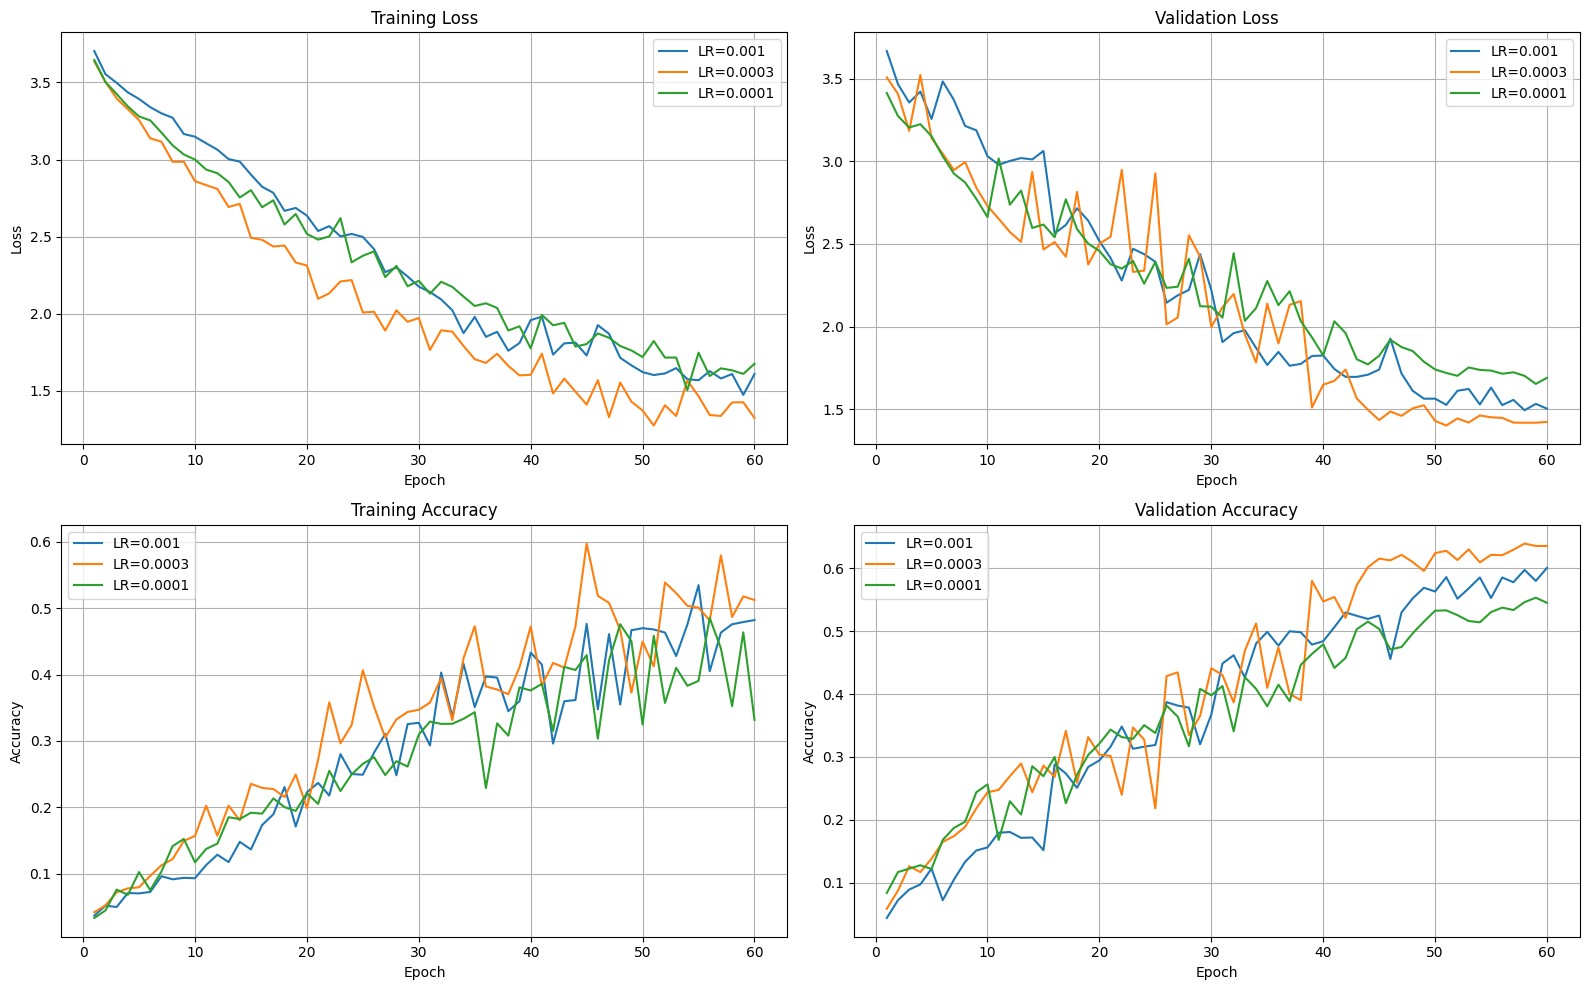

In [14]:
plt.figure(figsize=(16, 10))

#train
plt.subplot(2, 2, 1)
for r in results_lr:
    train_losses = r["history"]["train_loss"]
    plt.plot(
        range(1, len(train_losses) + 1),
        train_losses,
        label=f"LR={r['lr']}"
    )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

#validation
plt.subplot(2, 2, 2)
for r in results_lr:
    val_losses = r["history"]["val_loss"]
    plt.plot(
        range(1, len(val_losses) + 1),
        val_losses,
        label=f"LR={r['lr']}"
    )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.grid(True)
plt.legend()

#train accuracy 
plt.subplot(2, 2, 3)
for r in results_lr:
    train_accs = r["history"]["train_acc"]
    plt.plot(
        range(1, len(train_accs) + 1),
        train_accs,
        label=f"LR={r['lr']}"
    )
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.grid(True)
plt.legend()

#validation accuracy 
plt.subplot(2, 2, 4)
for r in results_lr:
    val_accs = r["history"]["val_acc"]
    plt.plot(
        range(1, len(val_accs) + 1),
        val_accs,
        label=f"LR={r['lr']}"
    )
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Comments on the learning rate values ablation
We performed an ablation study on the learning rate to understand how it affects convergence and generalization of our DeepResidualCNN. 
All other training settings were kept fixed:
* Optimizer: AdamW, weight decay = 2e-3
* Scheduler: ReduceLROnPlateau
* Regularization: Mixup 0.2, label smoothing 0.1, dropout 0.3


The best test accuracy is achieved with LR = 1e-3, while LR = 1e-4 shows worst performances

With 3e-4, optimization is easier the train loss curves goes down faster compared to the 1e-4 but the validation loss at the end goes a bit up and it's higher at the end compared to 1e-3. In the training loss the 1e-4 which is slower and it learns worst in 60 epochs and it stays worse also for the validation loss. 

* 1e-4 is too small for this problem and training length, gradients updates are small, the model improves slowly.
* 1e-3 gives the best test accuracy but also 3e-3 has a good accuracy but a bit larger learning rate can act as an implicit regularizer.

## MIXUP ABLATION

In [15]:
mixup_values = [0.0, 0.4]

In [ ]:
def run_mixup_ablation(mixup_alpha, train_loader, val_loader, test_loader, device):
    print(f"\n MixUp coefficient = {mixup_alpha}")

    model = DeepResidualCNN(
        num_classes=37, 
        dropout_probability=0.3
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=5e-4,
        weight_decay=2e-3
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode="min", 
        factor=0.5, 
        patience=3
    )

    best_val_acc, best_params, best_epoch, history = train_model_with_mixup(
        model=model,
        training_loader=training_loader,
        num_epochs=60,
        optimizer=optimizer,
        device=device,
        validation_loader=validation_loader,
        learning_rate_scheduler=scheduler,
        mixup_alpha=mixup_alpha,
        label_smoothing=0.1,
        early_stopping_patience=15,
        print_every=5
    )

    if best_params is not None:
        model.load_state_dict(best_params)

    val_acc = evaluate_accuracy(model, validation_loader, device)
    test_acc = evaluate_accuracy(model, test_loader, device)

    print(
        f"MixUp {mixup_alpha} | best epoch {best_epoch} | "
        f"val accuracy {val_acc:.3f} | test accuracy {test_acc:.3f}"
    )

    return {
        "mixup_alpha": mixup_alpha,
        "best_epoch": best_epoch,
        "val_acc": val_acc,
        "test_acc": test_acc,
        "history": history
    }

results_mixup = []

for alpha in mixup_values:
    results_mixup.append(
        run_mixup_ablation(
            alpha, 
            training_loader,      
            validation_loader,    
            test_loader, 
            device)
    )

df_mixup = pd.DataFrame([{
    "mixup_alpha": r["mixup_alpha"],
    "best_epoch": r["best_epoch"],
    "val_acc": r["val_acc"],
    "test_acc": r["test_acc"]
} for r in results_mixup])

df_mixup



 MixUp coefficient = 0.0


  2%|▏         | 1/60 [01:03<1:02:49, 63.89s/it]

Epoch 000 | train loss 3.641 train accuracy: 0.051 | val loss 3.556 val accuracy: 0.078 | best val accuracy 0.078 found at 000 epoch


 10%|█         | 6/60 [06:15<56:20, 62.60s/it]  

Epoch 005 | train loss 3.022 train accuracy: 0.188 | val loss 3.090 val accuracy: 0.165 | best val accuracy 0.165 found at 005 epoch


 18%|█▊        | 11/60 [11:27<50:50, 62.26s/it]

Epoch 010 | train loss 2.547 train accuracy: 0.341 | val loss 2.669 val accuracy: 0.246 | best val accuracy 0.246 found at 010 epoch


 27%|██▋       | 16/60 [16:36<45:28, 62.01s/it]

Epoch 015 | train loss 2.150 train accuracy: 0.481 | val loss 2.389 val accuracy: 0.341 | best val accuracy 0.341 found at 015 epoch


 28%|██▊       | 17/60 [17:38<44:22, 61.93s/it]

In [ ]:
plt.figure(figsize=(16, 10))

#train 
plt.subplot(2, 2, 1)
for r in results_mixup:
    train_losses = r["history"]["train_loss"]
    plt.plot(
        range(1, len(train_losses) + 1),
        train_losses,
        label=f"MixUp={r['mixup_alpha']}"
    )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

#validation 
plt.subplot(2, 2, 2)
for r in results_mixup:
    val_losses = r["history"]["val_loss"]
    plt.plot(
        range(1, len(val_losses) + 1),
        val_losses,
        label=f"MixUp={r['mixup_alpha']}"
    )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.grid(True)
plt.legend()

#train accuracy 
plt.subplot(2, 2, 3)
for r in results_mixup:
    train_accs = r["history"]["train_acc"]
    plt.plot(
        range(1, len(train_accs) + 1),
        train_accs,
        label=f"MixUp={r['mixup_alpha']}"
    )
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.grid(True)
plt.legend()

#validation accuracy 
plt.subplot(2, 2, 4)
for r in results_mixup:
    val_accs = r["history"]["val_acc"]
    plt.plot(
        range(1, len(val_accs) + 1),
        val_accs,
        label=f"MixUp={r['mixup_alpha']}"
    )
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## LABEL SMOOTHING ABLATION

In [ ]:
label_smoothing_values = [0.0, 0.4]

In [ ]:
def label_smoothing_ablation(label_smoothing_value, train_loader, val_loader, test_loader, device):
    print(f"\n Label Smoothing = {label_smoothing_value}")

    model = DeepResidualCNN(
        num_classes=37,
        dropout_probability=0.3
    ).to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=5e-4,
        weight_decay=2e-3
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=3
    )

    best_val_acc, best_params, best_epoch, history = train_model_with_mixup(
        model=model,
        training_loader=training_loader,
        num_epochs=60,                     
        optimizer=optimizer,
        device=device,
        validation_loader=validation_loader,
        learning_rate_scheduler=scheduler,
        mixup_alpha=0.2,
        label_smoothing=label_smoothing_value,
        early_stopping_patience=15,
        print_every=5
    )

    if best_params is not None:
        model.load_state_dict(best_params)

    val_acc = evaluate_accuracy(model, validation_loader, device)
    test_acc = evaluate_accuracy(model, test_loader, device)

    print(
        f"Label smoothing {label_smoothing_value} | "
        f"best epoch {best_epoch} | "
        f"val accuracy {val_acc:.3f} | "
        f"test accuracy {test_acc:.3f}"
    )

    return {
        "name": f"label_smoothing={label_smoothing_value}",
        "label_smoothing": label_smoothing_value,
        "best_epoch": best_epoch,
        "val_acc": val_acc,
        "test_acc": test_acc,
        "history": history
    }

results_label_smoothing = []

for ls in label_smoothing_values:
    results_label_smoothing.append(
        label_smoothing_ablation(
            ls,
            training_loader,
            validation_loader,
            test_loader,
            device
        )
    )

df_label_smoothing = pd.DataFrame([{
    "label_smoothing": r["label_smoothing"],
    "best_epoch": r["best_epoch"],
    "val_acc": r["val_acc"],
    "test_acc": r["test_acc"]
} for r in results_label_smoothing])

df_label_smoothing

In [ ]:
plt.figure(figsize=(16, 10))

#train
plt.subplot(2, 2, 1)
for r in results_label_smoothing:
    train_losses = r["history"]["train_loss"]
    plt.plot(
        range(1, len(train_losses) + 1),
        train_losses,
        label=f"LS={r['label_smoothing']}"
    )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

#validation
plt.subplot(2, 2, 2)
for r in results_label_smoothing:
    val_losses = r["history"]["val_loss"]
    plt.plot(
        range(1, len(val_losses) + 1),
        val_losses,
        label=f"LS={r['label_smoothing']}"
    )
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.grid(True)
plt.legend()

#train accuracy
plt.subplot(2, 2, 3)
for r in results_label_smoothing:
    train_accs = r["history"]["train_acc"]
    plt.plot(
        range(1, len(train_accs) + 1),
        train_accs,
        label=f"LS={r['label_smoothing']}"
    )
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.grid(True)
plt.legend()

#validation accuracy 
plt.subplot(2, 2, 4)
for r in results_label_smoothing:
    val_accs = r["history"]["val_acc"]
    plt.plot(
        range(1, len(val_accs) + 1),
        val_accs,
        label=f"LS={r['label_smoothing']}"
    )
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## AUGMENTATION ABLATION

In [ ]:
IMAGE_SIZE = 224
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 128
NUM_DATALOADER_WORKERS = 0

TRAINING_SET_MEAN_RGB = (0.4908042550086975, 0.4524926245212555, 0.3973051905632019)
TRAINING_SET_STD_RGB  = (0.2626195549964905, 0.2577695846557617, 0.2646913528442383)


training_transforms_nocolorjitter_norandaugment_norandomerasing = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),

    #transforms.ColorJitter(
        #brightness=0.15,
        #contrast=0.15,
        #saturation=0.15,
        #hue=0.02
    #),

    #transforms.RandAugment(
        #num_ops=2, 
        #magnitude=9
    #),

    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),

    #transforms.RandomErasing(
        #p=0.25,
        #scale=(0.02, 0.12),
        #ratio=(0.3, 3.3)
    #),
])


evaluation_transforms_nocolorjitter_norandaugment_norandomerasing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),
])

training_dataset = OxfordPetDataset(split="train", transform=training_transforms_nocolorjitter_norandaugment_norandomerasing)
validation_dataset = OxfordPetDataset(split="val", transform=evaluation_transforms_nocolorjitter_norandaugment_norandomerasing)
test_dataset = OxfordPetDataset(split="test", transform=evaluation_transforms_nocolorjitter_norandaugment_norandomerasing)


training_loader = DataLoader(
    training_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = DeepResidualCNN(
    num_classes=37, 
    dropout_probability=0.3
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4,
    weight_decay=2e-3
)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode="min", 
    factor=0.5, 
    patience=3
)

num_epochs = 60

best_val_acc, best_params, best_epoch, history = train_model_with_mixup(
    model=model,
    training_loader=training_loader,         
    num_epochs=num_epochs,
    optimizer=optimizer,
    device=device,
    validation_loader=validation_loader,         
    learning_rate_scheduler=lr_scheduler,
    mixup_alpha=0.2,
    label_smoothing=0.1,
    early_stopping_patience=15,
    print_every=5
)

if best_params is not None:
    model.load_state_dict(best_params)

print("Best epoch:", best_epoch)
final_val_acc = evaluate_accuracy(model, validation_loader, device)
final_test_acc = evaluate_accuracy(model, test_loader, device)

print("Validation accuracy:", final_val_acc)
print("Test accuracy:", final_test_acc)

train_losses = history["train_loss"]
val_losses   = history["val_loss"]
train_accs   = history["train_acc"]
val_accs     = history["val_acc"]


In [ ]:
plt.figure(figsize=(14, 5))

#loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
if len(validation_losses) > 0:
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

#accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label="Train Accuracy")
if len(validation_accuracy) > 0:
    plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
IMAGE_SIZE = 224
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 128
NUM_DATALOADER_WORKERS = 0

TRAINING_SET_MEAN_RGB = (0.4908042550086975, 0.4524926245212555, 0.3973051905632019)
TRAINING_SET_STD_RGB  = (0.2626195549964905, 0.2577695846557617, 0.2646913528442383)


training_transforms_norandaugment_norandomerasing = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.15,
        hue=0.02
    ),

    #transforms.RandAugment(
        #num_ops=2, 
        #magnitude=9
    #),

    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),

    #transforms.RandomErasing(
        #p=0.25,
        #scale=(0.02, 0.12),
        #ratio=(0.3, 3.3)
    #),
])


evaluation_transforms_norandaugment_norandomerasing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),
])

training_dataset = OxfordPetDataset(split="train", transform=training_transforms_nocolorjitter_norandaugment_norandomerasing)
validation_dataset = OxfordPetDataset(split="val", transform=evaluation_transforms_nocolorjitter_norandaugment_norandomerasing)
test_dataset = OxfordPetDataset(split="test", transform=evaluation_transforms_nocolorjitter_norandaugment_norandomerasing)


training_loader = DataLoader(
    training_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)


In [ ]:
IMAGE_SIZE = 224
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 128
NUM_DATALOADER_WORKERS = 0

TRAINING_SET_MEAN_RGB = (0.4908042550086975, 0.4524926245212555, 0.3973051905632019)
TRAINING_SET_STD_RGB  = (0.2626195549964905, 0.2577695846557617, 0.2646913528442383)


training_transforms_norandaugment_norandomerasing = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.15,
        hue=0.02
    ),

    #transforms.RandAugment(
        #num_ops=2, 
        #magnitude=9
    #),

    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),

    #transforms.RandomErasing(
        #p=0.25,
        #scale=(0.02, 0.12),
        #ratio=(0.3, 3.3)
    #),
])


evaluation_transforms_norandaugment_norandomerasing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),
])

training_dataset = OxfordPetDataset(split="train", transform=training_transforms_nocolorjitter_norandaugment_norandomerasing)
validation_dataset = OxfordPetDataset(split="val", transform=evaluation_transforms_nocolorjitter_norandaugment_norandomerasing)
test_dataset = OxfordPetDataset(split="test", transform=evaluation_transforms_nocolorjitter_norandaugment_norandomerasing)


training_loader = DataLoader(
    training_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = DeepResidualCNN(
    num_classes=37, 
    dropout_probability=0.3
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4,
    weight_decay=2e-3
)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode="min", 
    factor=0.5, 
    patience=3
)

num_epochs = 60

best_val_acc, best_params, best_epoch, history = train_model_with_mixup(
    model=model,
    training_loader=training_loader,         
    num_epochs=num_epochs,
    optimizer=optimizer,
    device=device,
    validation_loader=validation_loader,         
    learning_rate_scheduler=lr_scheduler,
    mixup_alpha=0.2,
    label_smoothing=0.1,
    early_stopping_patience=15,
    print_every=5
)

if best_params is not None:
    model.load_state_dict(best_params)

print("Best epoch:", best_epoch)
final_val_acc = evaluate_accuracy(model, validation_loader, device)
final_test_acc = evaluate_accuracy(model, test_loader, device)

print("Validation accuracy:", final_val_acc)
print("Test accuracy:", final_test_acc)

train_losses = history["train_loss"]
val_losses   = history["val_loss"]
train_accs   = history["train_acc"]
val_accs     = history["val_acc"]


In [ ]:
plt.figure(figsize=(14, 5))

#loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
if len(validation_losses) > 0:
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

#accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label="Train Accuracy")
if len(validation_accuracy) > 0:
    plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
IMAGE_SIZE = 224
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 128
NUM_DATALOADER_WORKERS = 0

TRAINING_SET_MEAN_RGB = (0.4908042550086975, 0.4524926245212555, 0.3973051905632019)
TRAINING_SET_STD_RGB  = (0.2626195549964905, 0.2577695846557617, 0.2646913528442383)


training_transforms_norandaugment_norandomerasing = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),

    #transforms.ColorJitter(
        #brightness=0.15,
        #contrast=0.15,
        #saturation=0.15,
        #hue=0.02
    #),

    transforms.RandAugment(
        num_ops=2, 
        magnitude=9
    ),

    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),

    #transforms.RandomErasing(
        #p=0.25,
        #scale=(0.02, 0.12),
        #ratio=(0.3, 3.3)
    #),
])


evaluation_transforms_norandaugment_norandomerasing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),
])

training_dataset = OxfordPetDataset(split="train", transform=training_transforms_nocolorjitter_norandaugment_norandomerasing)
validation_dataset = OxfordPetDataset(split="val", transform=evaluation_transforms_nocolorjitter_norandaugment_norandomerasing)
test_dataset = OxfordPetDataset(split="test", transform=evaluation_transforms_nocolorjitter_norandaugment_norandomerasing)


training_loader = DataLoader(
    training_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = DeepResidualCNN(
    num_classes=37, 
    dropout_probability=0.3
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4,
    weight_decay=2e-3
)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode="min", 
    factor=0.5, 
    patience=3
)

num_epochs = 60

best_val_acc, best_params, best_epoch, history = train_model_with_mixup(
    model=model,
    training_loader=training_loader,         
    num_epochs=num_epochs,
    optimizer=optimizer,
    device=device,
    validation_loader=validation_loader,         
    learning_rate_scheduler=lr_scheduler,
    mixup_alpha=0.2,
    label_smoothing=0.1,
    early_stopping_patience=15,
    print_every=5
)

if best_params is not None:
    model.load_state_dict(best_params)

print("Best epoch:", best_epoch)
final_val_acc = evaluate_accuracy(model, validation_loader, device)
final_test_acc = evaluate_accuracy(model, test_loader, device)

print("Validation accuracy:", final_val_acc)
print("Test accuracy:", final_test_acc)

train_losses = history["train_loss"]
val_losses   = history["val_loss"]
train_accs   = history["train_acc"]
val_accs     = history["val_acc"]


In [ ]:
plt.figure(figsize=(14, 5))

#loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
if len(validation_losses) > 0:
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

#accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label="Train Accuracy")
if len(validation_accuracy) > 0:
    plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
IMAGE_SIZE = 224
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 128
NUM_DATALOADER_WORKERS = 0

TRAINING_SET_MEAN_RGB = (0.4908042550086975, 0.4524926245212555, 0.3973051905632019)
TRAINING_SET_STD_RGB  = (0.2626195549964905, 0.2577695846557617, 0.2646913528442383)


training_transforms_norandaugment_norandomerasing = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),

    #transforms.ColorJitter(
        #brightness=0.15,
        #contrast=0.15,
        #saturation=0.15,
        #hue=0.02
    #),

    #transforms.RandAugment(
        #num_ops=2, 
        #magnitude=9
    #),

    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),

    transforms.RandomErasing(
        p=0.25,
        scale=(0.02, 0.12),
        ratio=(0.3, 3.3)
    ),
])


evaluation_transforms_norandaugment_norandomerasing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(TRAINING_SET_MEAN_RGB, TRAINING_SET_STD_RGB),
])

training_dataset = OxfordPetDataset(split="train", transform=training_transforms_nocolorjitter_norandaugment_norandomerasing)
validation_dataset = OxfordPetDataset(split="val", transform=evaluation_transforms_nocolorjitter_norandaugment_norandomerasing)
test_dataset = OxfordPetDataset(split="test", transform=evaluation_transforms_nocolorjitter_norandaugment_norandomerasing)


training_loader = DataLoader(
    training_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=EVAL_BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS,
    pin_memory=True
)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model = DeepResidualCNN(
    num_classes=37, 
    dropout_probability=0.3
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=5e-4,
    weight_decay=2e-3
)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode="min", 
    factor=0.5, 
    patience=3
)

num_epochs = 60

best_val_acc, best_params, best_epoch, history = train_model_with_mixup(
    model=model,
    training_loader=training_loader,         
    num_epochs=num_epochs,
    optimizer=optimizer,
    device=device,
    validation_loader=validation_loader,         
    learning_rate_scheduler=lr_scheduler,
    mixup_alpha=0.2,
    label_smoothing=0.1,
    early_stopping_patience=15,
    print_every=5
)

if best_params is not None:
    model.load_state_dict(best_params)

print("Best epoch:", best_epoch)
final_val_acc = evaluate_accuracy(model, validation_loader, device)
final_test_acc = evaluate_accuracy(model, test_loader, device)

print("Validation accuracy:", final_val_acc)
print("Test accuracy:", final_test_acc)

train_losses = history["train_loss"]
val_losses   = history["val_loss"]
train_accs   = history["train_acc"]
val_accs     = history["val_acc"]


In [ ]:
plt.figure(figsize=(14, 5))

#loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
if len(validation_losses) > 0:
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

#accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label="Train Accuracy")
if len(validation_accuracy) > 0:
    plt.plot(range(1, len(validation_accuracy) + 1), validation_accuracy, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
